In [ ]:
!pip install speechpy


In [ ]:
import speechpy

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.8 MB/s eta 0:00:00


In [ ]:
!pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.10/dist-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, datascience, fastai, flax, geemap, imgaug, matplotlib-venn, missingno, mizani, mlxtend, music21, plotnine, prophet, pycocotools, seaborn, wordcloud, yellowbrick


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


**Import LJSpeech Dataset**


*   **ID**: name of the corresponding .wav flie
*   **Transcription**: words spoken by reader
*   **Normalised Transcription**: transcription with numbers, ordinals and monetory units expanded into full words.






In [ ]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

In [ ]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting = 3)

In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["File_name", "Transcription", "Normalised_Transcription"]
metadata_df = metadata_df[["File_name", "Normalised_Transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,File_name,Normalised_Transcription
0,LJ021-0023,and the great transporting and manufacturing a...
1,LJ025-0173,"The watery solution, in which its roots are pl..."
2,LJ028-0296,thou coverest the foulest deeds with the faire...


We now split the data into training and validation set

In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


**Preprocessing**

We will first prepare the vocabulary to be used

In [ ]:
#The set of characters accepted in transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
#Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
#Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


Next, we create the function that describes the transformation that we apply to each element of our data set

In [ ]:
#An integer scalar Tensor, The window length in samples
frame_length = 256
#An integer scalar Tensor, Thenumber of samples to step
frame_step = 160
#An integer scalar Tensor. The size of FFT to apply
fft_length = 384

def encode_single_sample(wav_file, label):
  #1. Read wav file
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  #2. Decode the wav file
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  #3. Change type to float
  audio = tf.cast(audio, tf.float32)
  #4. Get the spectrogram
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  #5. We only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  #6.Normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  #7. Convert label to lower case
  label = tf.strings.lower(label)
  #8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")
  #9. Map the characters in label to numbers
  label = char_to_num(label)
  #10. Return a dict as our model is expecting two inputs
  return spectrogram, label



**Creating Dataset Objects**

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["File_name"]), list(df_train["Normalised_Transcription"]))
)
train_dataset = (train_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["File_name"]), list(df_val["Normalised_Transcription"]))
)
validation_dataset = (validation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


**Visualize the data**

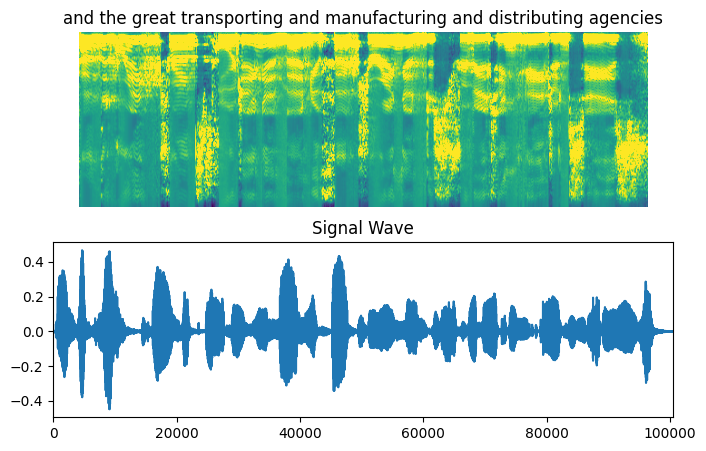

In [ ]:

fig = plt.figure(figsize = (8, 5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  #Spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  #Wav
  file = tf.io.read_file(wavs_path + list(df_train["File_name"])[0] + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

**Model**

Defining the CTC Loss

In [ ]:
def CTCLoss(y_true, y_pred):
  #Compute the training-time loss value
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
  # Model's input
  input_spectrogram = layers.Input((None, input_dim), name="input")
  # Expand the dimension to use 2D CNN
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
  # Convolution layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2, 2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  # Convolution layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  # Reshape the resulted volume to feed the RNNs layers
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  # RNN layers
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}", merge_mode="concat"
    )(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)
  # Dense layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  # Classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
  # Model
  model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
  # Optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  # Compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

**Training and Evaluate**

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
  output_text = []
  for result in results:
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch: int, logs=None):
    predictions = []
    targets = []
    for batch in self.dataset:
      X, y = batch
      batch_predictions = model.predict(X)
      batch_predictions = decode_batch_predictions(batch_predictions)
      predictions.extend(batch_predictions)
      for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score: 4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
      print(f"Target    : {targets[i]}")
      print(f"Prediction: {predictions[i]}")
      print("-" * 100)

Starting the training process


In [ ]:
epochs = 2
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/2
 21/369 [>.............................] - ETA: 27:01:10 - loss: 538.0490

**Inference**

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
  X, y = batch
  batch_predictions = model.predict(X)
  batch_predictions = decode_batch_predictions(batch_predictions)
  predictions.extend(batch_predictions)
  for label in y:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
  print(f"Target    : {targets[i]}")
  print(f"Prediction: {predictions[i]}")
  print("-" * 100)

Conclusion

In practice, we must train for around 50 epochs or more. Each epoch takes approximately 5-6 min using a Geforce RTX 2000 Ti GPU. The we train has a Word Error Rate (WER) = 16% to 17%.

